In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sympy as sp


dt = 0.0001   #s
t_ini = 0
t_fin = 60    #s
timeline = np.arange(t_ini, t_fin, dt)


t_pstc = 0.01
def diracDelta(x):
    #la dirac delta devuelve entre  y = [0,1]
    return np.exp(-(x/t_pstc)**2)


class LIF_Parameters:
    Rm = 10e6              #Resistencia de membrana 10MOhms (10e6)
    Cm = 1e-9               #Capacitancia de membrana 1nF (1e-9)
    tm = Rm * Cm         #constante temporal membrana 10ms [ms]
    El = -0.070             #voltaje de reposo  mV
    vth = -0.055            #voltaje de  umbral mV
    vspike = 0.020          #voltaje de disparo mV
    tref = 0.002            #periodo refractario 2ms

class LIF(LIF_Parameters):
    def __init__(self):
        self.V = self.El            #iniciando con el coltaje de reposo
        self.last_tf = 0            #instante del ultimo disparo (para periodo refractario)
        self.Isyn = 0               #corriente de entrada. Por defecto 0nA
        self.firing_hist = []       #no hay disparo al inicio de la ejecuion
        self.Isyn_hist = []         #historial de la corriente de entrada a la neurona
        self.Vm_hist = []
        self.Vs_hist = []

    def simulate(p, t, Isyn):
        if((t-p.last_tf)>=p.tref):                      #si no nos encontramos en el periodo refractario
            dV = (p.El - p.V + p.Rm * Isyn)/p.tm        #se integra la nueva corriente
        else:                                           #estamos en periodo refractario, Vm debe tender a El
            dV = dV = (p.El - p.V + p.Rm * 0)/p.tm      #en periodo refractario no se integra nueva corriente

        p.V = p.V + dt * dV                             #integrando el voltaje de neurona

        if(p.V >= p.vth):                               #si el voltaje de membrana es superado
            p.V = p.El                                  #se resetea el voltaje de membrana
            p.last_tf = t                               #instante del ultimo disparo (para periodo refractario)
            p.firing_hist.append(t)                     #agregando el nuevo tiempo de disparo
        elif(p.V<p.El):                                 #se evita que el voltaje se vaya negativvo
            p.V = p.El

        Vs = p.vspike * diracDelta(t - p.last_tf)                       #la salda es un impulso de amplitud maxima 20mV

        p.Isyn_hist.append(Isyn)
        p.Vm_hist.append(p.V)
        p.Vs_hist.append(Vs)

        return Vs

class LIFConductance(LIF):
    Csyn = 1e-5                 #Constante of injection current   https://doi.org/10.1016/j.neucom.2021.06.027
    tsyn = 0.010                #tiempo de decaimiento de la inyeccion de corriente
    def simulate(p, t,  Ewij_dd):
        if((t-p.last_tf)>=p.tref):                              #si no nos encontramos en el periodo refractario
            dIsyn = (1/p.tsyn) * (-p.Isyn + p.Csyn * Ewij_dd)   #se calcula la corriente de entrada
        else:                                                   #estamos en periodo refractario, Vm debe tender a El
            dIsyn = 0                                           #en periodo refractario no se integra nueva corriente
        
        dV = (p.El - p.V + p.Rm * dIsyn)/p.tm      
        p.Isyn = p.Isyn + dt * dIsyn
        p.V = p.V + dt * dV                             

        if(p.V >= p.vth):                       #si el voltaje de membrana es superado
            p.V = p.El                      #se resetea el voltaje de membrana
            p.last_tf = t                       #se registra el tiempo de disparo
            p.firing_hist.append(t)             #agregando el nuevo tiempo de disparo
        elif(p.V<p.El):                     #se evita que el voltaje se vaya negativvo
            p.V = p.El

        Vs = p.vspike * diracDelta(t - p.last_tf)                       #la salda es un impulso de amplitud maxima 20mV

        p.Isyn_hist.append(p.Isyn)
        p.Vm_hist.append(p.V)
        p.Vs_hist.append(Vs)
        
        return Vs

class RSTDP:
    #la entrada de corriente de la neurona est en nano amperes (1e-9), el voltaje de salida en mV (1e-3)
    #ya que R =1/G y v = IR,  v = I/G , o bien G = I/v  = 1e-9/1e-3 = 1e-6  (microsiemens)
    Ap = 1            #10 uS por spike
    Am = -Ap
    tE = 0.010          #milisegundos
    def __init__(self, w_init, wmax, wmin):
        self.wmax = wmax
        self.wmin = wmin
        self.w = w_init
        self.E = 0             
        self.dE = 0
        self.w_hist = []
    
    def simulate(self, dd_prev, dd_post, R):
        Wpre =  self.Ap * dd_prev 
        Wpost = self.Am * dd_post
        dE = (-self.E/self.tE) + Wpre + Wpost
        self.E = self.E + dt * dE
        dw = R * self.E
        self.w = self.w + dt * dw
        if(self.w<self.wmin):
            self.w = self.wmin
        # elif(self.w>self.wmax):
        #     self.w = self.wmax
        self.w_hist.append(self.w)
        return self.w

class StepFowardEncoder:
    c = 1
    def __init__(self,Ic,  thr):
        self.base = 0
        self.thr = thr
        self.Ic = Ic
    
    def encode(self, x):
        alpha = np.tanh(self.c * (x - self.base))
        IcP = (1+alpha) * self.Ic
        IcN = (1-alpha) * self.Ic
        self.base = self.base + self.thr * alpha
        return IcP, IcN

class StepFowardDecoder:
    def __init__(self, thr):
        self.base = 0
        self.thr = thr
        self.out_hist = []

    def decode(self, vs_pos, vs_neg):
        self.base = self.base + self.thr * vs_pos - self.thr * vs_neg
        self.out_hist.append(self.base)
        return self.base

class SNN:
    def __init__(self, n, m, w_max, w_min):
        self.n = n
        self.m = m
        self.j_layer = np.array([LIF() for _ in range(n)])
        self.k_layer = np.array([LIFConductance() for _ in range(m)])
        self.R = np.ones(m) 

        #synapses
        self.wjk = w_min + np.random.rand(n, m) * (w_max - w_min)            #inicializando pesos sinapticos de manera aleatoria, entre wmin wmax
        self.synapses = np.empty((n, m), dtype = object)                        #creando un array de objetos tipo synapsis
        for (j,k), syn in np.ndenumerate(self.synapses):                        #inicializando cada objeto tipo sinapsis, con su valor inicial
            self.synapses[j,k] = RSTDP(self.wjk[j,k], w_max, w_min)      
        
    def simulate(self, t, I_j):
        #disparos de la primer capa
        vs_j = np.zeros(self.n)
        for j, neuron in enumerate(self.j_layer):
            vs_j[j] = neuron.simulate(t,I_j[j])

        #disparos de la segunda capa
        I_k = np.dot(vs_j, self.wjk)
        vs_k = np.zeros(self.m)
        for k, neuron in enumerate(self.k_layer):
            vs_k[k] = neuron.simulate(t,I_k[k])

        #actualizando pesos sinapticos 
        for (j,k), syn in np.ndenumerate(self.synapses):                     #actualizando sinapsis wj
            self.wjk[j,k] = syn.simulate(vs_j[j],  vs_k[k], self.R[k])           #guardando los pesos sinapticos  para la siguiente iteracion

        return vs_k


SNNP = SNN(3,2,1e-3, 1e-6)
SNNN = SNN(3,2,1e-3, 1e-6)
Encoders = [StepFowardEncoder(1.5e-9, 1e-4) for i in range(3)]
Decoders = [StepFowardDecoder(1e-5) for j in range(2)]

mu = 3
x1 = sp.symbols('x_1')                                                      #estados del lorenz
A = sp.Matrix([[mu * (1 - (1/3) * x1**2), -mu],[1/mu, 0]])
taylor = (sp.eye(2) + (A * dt)/1 
           + (((A * dt)**2)/2) 
           + (((A * dt)**3)/6) 
           +  (((A * dt)**4)/24) 
           +  (((A * dt)**5)/120))
Fx = sp.lambdify(x1, taylor)                                                 
C = np.array([1,0])                                    #matriz de salida del sistema

nu = 0.1        #potencia de ruido en decibeles (pertubaciones de sistema vs medicion)
r = 0.1        #desviacion standard del ruido de medicion
r_sq = r**2      
q_sq = r_sq * nu
Q = np.eye(3) * q_sq
R = np.eye(1) * r_sq
q = np.sqrt(q_sq)

x = np.array([2 ,-1])            #estados iniciales del Lorenz
hx = np.array([0,0])              #estados iniciales de la preciccion
Kg = np.zeros(2)                    #ganancia de kalman

x_hist = []
y_hist = []
hx_hist = []
tiempo = []



In [2]:

error_lim = 500
for t in tqdm(timeline):

    wt = np.array([np.random.normal(0, q),                   #creando ruido para las senales de la planta 
                  np.random.normal(0, q)])
    vt = np.random.normal(0, r)                              #creando ruido para las senales de la planta a la salida
    
    # simulando la planta no lineal (Ground Truth) + ruido
    x = np.dot(Fx(x[0]),x) + wt
    y = np.dot(C, x) + vt
    
    #Paso 1 EKF: estimacion a priori
    hx_1 = np.dot(Fx(hx[0]),hx)
    hy_1 = np.dot(C, hx_1)

    dhxt = hx - hx_1                                                #calculando la diferencia entre lo predicho entre el paso anterior y la nueva prediccion
    dyt = y - hy_1                                                  #calculando la diferencia entre lo medido  y la nueva medicion predicha

    vector_input = [dhxt[0], dhxt[1], dyt]  #poniendo las senales de entrada de la red en un solo vector
    IcP_vector = []                                                 #Vector de corriente de exitacion para la capa j de la red SNNP
    IcN_vector = []                                                 #Vector de corriente de exitacion para la capa j de la red SNNN
    for j, encoder in enumerate(Encoders):                          #ciclo para iterar entre cada Encoder
        IcP, IcN = encoder.encode(vector_input[j])                  #codificando
        IcP_vector.append(IcP)                                      #agregando al vector de entrada correspondiente
        IcN_vector.append(IcN)

    vs_j_SNNP = SNNP.simulate(t, IcP_vector)                          #suministrando corriente de exitacion a la primer capa de la red SNNP, simulando salida 
    vs_j_SNNN = SNNN.simulate(t, IcN_vector)                          #suministrando corriente de exitacion a la primer capa de la red SNNN, simulando salida 

    for k, decoder in enumerate(Decoders):                          #iterando entre cada decoder para obtener la matriz de kalman
        Kg[k] = decoder.decode( vs_j_SNNP[k], vs_j_SNNN[k])        #obteniendo nuevo componente de la matriz de kalman

    hx = hx_1 + Kg * dyt 

    x_hist.append(x)
    y_hist.append(y)
    hx_hist.append(hx)
    tiempo.append(t)

    if(abs(hx[0]-x[0]) > error_lim or abs(hx[1]-x[1]) > error_lim):
        break
    
x_hist = np.matrix(x_hist)
hx_hist = np.matrix(hx_hist)

100%|██████████| 600000/600000 [02:22<00:00, 4196.48it/s]


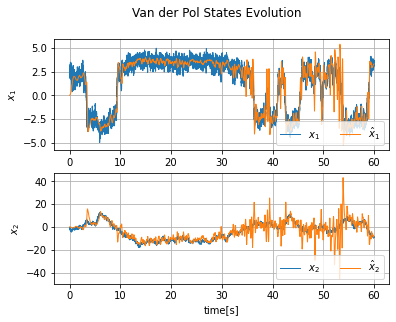

In [3]:

fig, ax = plt.subplots(2, figsize=(6, 4.5))
# ax[0].plot(tiempo, y_hist, label = "$y$", linewidth = 1)
for i in range(2):
    ax[i].plot(tiempo, x_hist[:,i], label = "$x_{}$".format(i+1), linewidth = 1)
    ax[i].plot(tiempo, hx_hist[:,i], label = "$\hat x_{}$".format(i+1), linewidth = 1)
    ax[i].legend(loc=4, ncol=2)
    ax[i].set(xlabel = 'time[s]' , ylabel = '$x_{}$'.format(i+1))
    ax[i].grid()
fig.suptitle("Van der Pol States Evolution")
fig.savefig('VanDerPolEv.pdf')


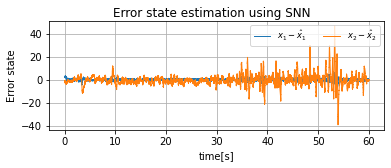

In [4]:
fig, ax = plt.subplots(1, figsize = (6,2))
for i in range(2):
    ax.plot(tiempo, x_hist[:,i]-hx_hist[:,i], label = "$x_{}-\hat x_{}$".format(i+1, i+1), linewidth=1)
ax.set(xlabel = 'time[s]' , ylabel = 'Error state')
ax.legend(loc=1, ncol=3, fontsize="small")
ax.grid()
fig.suptitle("Error state estimation using SNN")
fig.savefig('ErrorVanderPol.pdf')

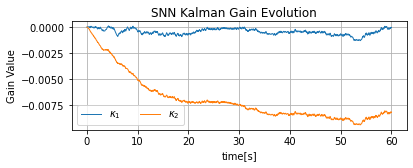

In [5]:
fig, ax = plt.subplots(1, figsize = (6, 2))
for k, decoder in enumerate(Decoders):
    ax.plot(tiempo, decoder.out_hist, label = "$\kappa_{}$".format(k+1), linewidth=1)
ax.legend(ncol=3)
fig.suptitle("SNN Kalman Gain Evolution")
ax.set(xlabel = 'time[s]' , ylabel = 'Gain Value')
ax.grid()
fig.savefig('KalmanGainVanDerPol.pdf')

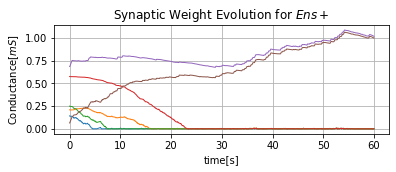

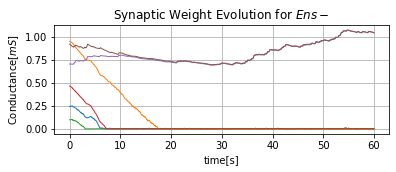

In [6]:

fig, ax1 = plt.subplots(1, figsize=(6, 2))
for (j,k), syn in np.ndenumerate(SNNP.synapses):
    ax1.plot(tiempo[::5], np.array(syn.w_hist[::5])*1000, linewidth=1)
ax1.set_title("Synaptic Weight Evolution for $Ens+$")
ax1.set(xlabel = 'time[s]' , ylabel = 'Conductance[$mS$]')
ax1.grid()
fig.savefig('WeightEvSNNP.pdf')

fig, ax2 = plt.subplots(1, figsize=(6, 2))
for (j,k), syn in np.ndenumerate(SNNN.synapses):
    ax2.plot(tiempo[::5], np.array(syn.w_hist[::5])*1000, linewidth=1)
ax2.set_title("Synaptic Weight Evolution for $Ens-$")
ax2.set(xlabel = 'time[s]' , ylabel = 'Conductance[$mS$]')
ax2.grid()
fig.savefig('WeightEvSNNN.pdf')


Text(0.5, 0.98, 'Spike Frecuency SNN- of $k-th$ layer')

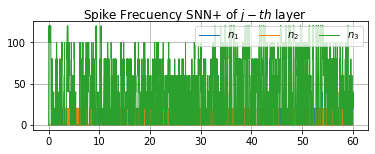

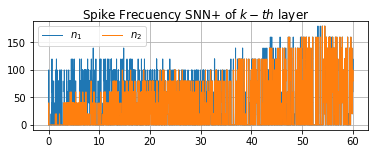

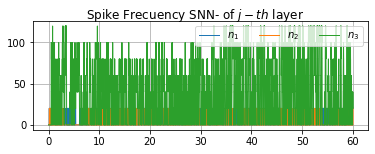

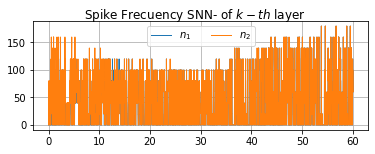

In [7]:

def frecuenciaDisaparo(T, timeline, spikes):
    frec_history = []
    for t in timeline:
        spikes_left = spikes[spikes < t]        #buscando los spikes dentro de la ventana T
        spikes_in = spikes_left[spikes_left >(t-T)]
        f = (len(spikes_in))  * (1/T)
        frec_history.append(f)
    return np.array(frec_history)

T = 0.05
fig, ax = plt.subplots(1, figsize=(6, 2))
for k,neuron in enumerate(SNNP.j_layer):
    frec_hist = frecuenciaDisaparo(T, tiempo, np.array(neuron.firing_hist))
    ax.plot(tiempo[::10], frec_hist[::10], label = "$n_{}$".format(k+1), linewidth=1)

ax.legend(loc = 1, ncol=4)
ax.grid()
fig.suptitle("Spike Frecuency SNN+ of $j-th$ layer")
# fig.savefig('SPKFRECSNNPjlayer.pdf')

fig, ax = plt.subplots(1, figsize=(6, 2))
for k,neuron in enumerate(SNNP.k_layer):
    frec_hist = frecuenciaDisaparo(T, tiempo, np.array(neuron.firing_hist))
    ax.plot(tiempo[::10], frec_hist[::10], label = "$n_{}$".format(k+1), linewidth=1)

ax.legend(ncol=3)
ax.grid()
fig.suptitle("Spike Frecuency SNN+ of $k-th$ layer")
# fig.savefig('SPKFRECSNNPklayer.pdf')


fig, ax = plt.subplots(1, figsize=(6, 2))
for k,neuron in enumerate(SNNN.j_layer):
    frec_hist = frecuenciaDisaparo(T, tiempo, np.array(neuron.firing_hist))
    ax.plot(tiempo[::10], frec_hist[::10], label = "$n_{}$".format(k+1), linewidth=1)

ax.legend(loc = 1,ncol=4)
ax.grid()
fig.suptitle("Spike Frecuency SNN- of $j-th$ layer")
# fig.savefig('SPKFRECSNNNjlayer.pdf')

fig, ax = plt.subplots(1, figsize=(6, 2))
for k,neuron in enumerate(SNNN.k_layer):
    frec_hist = frecuenciaDisaparo(T, tiempo, np.array(neuron.firing_hist))
    ax.plot(tiempo[::10], frec_hist[::10], label = "$n_{}$".format(k+1), linewidth=1)

ax.legend(ncol=3)
ax.grid()
fig.suptitle("Spike Frecuency SNN- of $k-th$ layer")
# fig.savefig('SPKFRECSNNNklayer.pdf')



In [8]:
x1,x2 = sp.symbols('x_1 x_2') 
f = taylor * sp.Matrix([[x1],[x2]])
A_jac = sp.lambdify((x1, x2),f.jacobian((x1, x2)),"numpy")
C = np.matrix(C)

Pkk = np.eye(2)
Pkk1 = np.eye(2)
Skk1 = np.eye(1)
tx = np.matrix([[0],[0]])              #estados iniciales de la preciccion
tx_hist = []
for y in tqdm(y_hist):
    #Paso 1 EKF: estimacion a priori
    tx_1 = Fx(tx[0,0]) * tx
    ty_1 = np.dot(C, tx_1)
    A_eval = A_jac(tx_1[0,0], tx_1[1,0])
    Pkk1 = A_eval * Pkk * A_eval.transpose() + np.eye(2)
    Skk1 = C * Pkk1 * C.transpose() + np.eye(1)

    #paso2 EKF: update
    kappa = Pkk1 * C.transpose() * np.linalg.inv(Skk1)
    tx = tx + kappa * (y - ty_1)
    Pkk = Pkk1 -  kappa * Skk1 * kappa.transpose()
    
    tx_hist.append(np.array([tx[0,0],tx[1,0]]))
    

hx_ekf_hist = np.matrix(tx_hist)




100%|██████████| 600000/600000 [02:09<00:00, 4625.40it/s]


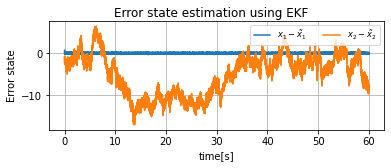

In [9]:
fig, ax = plt.subplots(1, figsize=(6,2))
for i in range(2):
    ax.plot(tiempo, x_hist[:,i]- hx_ekf_hist[:,i], label="$x_{} - \~x_{}$".format(i+1,i+1))
ax.set(xlabel = 'time[s]' , ylabel = 'Error state')
ax.legend(loc=1, ncol=3, fontsize="small")
ax.grid()
fig.suptitle("Error state estimation using EKF")
fig.savefig("ErrorEKFVanderPol.pdf")